### Case Study

Cryptocurrencies have gained significant attention in recent years due to their decentralized nature and potential for high returns. However, the volatility of cryptocurrency prices also presents a substantial challenge, not only for investors aiming to maximize returns but also for those needing precise price predictions for budgeting and financial planning.

In this case study, our goal is to predict the actual price of a cryptocurrency over a specified period using the eXtreme Gradient Boosting (XGBoost) algorithm. XGBoost is renowned for its efficiency and performance in handling complex datasets with high dimensionality, making it an excellent choice for modeling the often unpredictable cryptocurrency market.

By leveraging historical price data along with relevant market indicators, this case study will demonstrate how to train an XGBoost model in a Jupyter Notebook environment to forecast the future prices of a cryptocurrency. Accurate price predictions can provide critical insights for traders and investors, enabling them to make better-informed decisions and manage their financial risks more effectively in the volatile cryptocurrency market.

### Imports

In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
import os

# Data Extraction
import ccxt
import ta

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import roc_curve, RocCurveDisplay

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Extraction and Historical Prive Overview


In [2]:
# Settings
is_new_data = False
symbol = "BTCUSDT"
timeframe = "1d"

In [ ]:
class BinanceManager:
    def __init__(self, api_key=None, secret_key=None):
        self.binance = ccxt.binance()
        self.binance.apiKey = api_key
        self.binance.secret = secret_key
        self.binance.load_markets()

    def get_historical_data(self, symbol, timeframe, since, limit=None):
        since = self.__str_to_timestamp(since)
        data = []
        limit_remaining = float('inf') if limit is None else limit
        while limit_remaining > 0:
            fetch_limit = min(limit_remaining, 500)  # Maximum fetch limit for Binance
            chunk_data = self.binance.fetch_ohlcv(symbol, timeframe, since=since, limit=fetch_limit)
            data.extend(chunk_data)
            if len(chunk_data) < fetch_limit:
                break  # No more data available
            since = chunk_data[-1][0] + 1  # Update 'since' to fetch next chunk
            limit_remaining -= fetch_limit

        df = pd.DataFrame(data, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        df.set_index('datetime', inplace=True)
        return df

    def load_previous_data(self, symbol, timeframe):
        df = pd.read_csv(f'data/{symbol}_{timeframe}.csv')
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        return df
    def __str_to_timestamp(self, str_date):
        return int(pd.to_datetime(str_date).timestamp() * 1000)

    def get_all_ta_features(self, df):
        df = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
        return df

    def get_bollinger_bands(self, df, period=20):
        df['bb_bands'] = ta.volatility.bollinger_hband(df['close'], n=period)
        df['bb_bands'] = df['bb_bands'].shift(1)
        return df

    def get_rsi(self, df, period=14):
        df['rsi'] = ta.momentum.rsi(df['close'], n=period)
        return df

    def get_macd(self, df, period_fast=12, period_slow=26, period_signal=9):
        df['macd'] = ta.trend.macd_diff(df['close'], n_fast=period_fast, n_slow=period_slow, n_sign=period_signal)
        return df

    def get_ema(self, df, period=20):
        df['ema'] = ta.trend.ema_indicator(df['close'], n=period)
        return df

    def get_sma(self, df, period=20):
        df['sma'] = ta.trend.sma_indicator(df['close'], n=period)
        return df

In [3]:
# Data Extraction

bm = BinanceManager()
if is_new_data:
    since = "1 Jan 2017"
    bm_df = bm.get_historical_data(symbol=symbol, timeframe=timeframe, since=since)

else:
    bm_df = bm.load_previous_data(symbol=symbol, timeframe=timeframe)

df_orig = bm_df.copy()
df_orig

,open,high,low,close,volume
datetime,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.736590
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.909030
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.160050


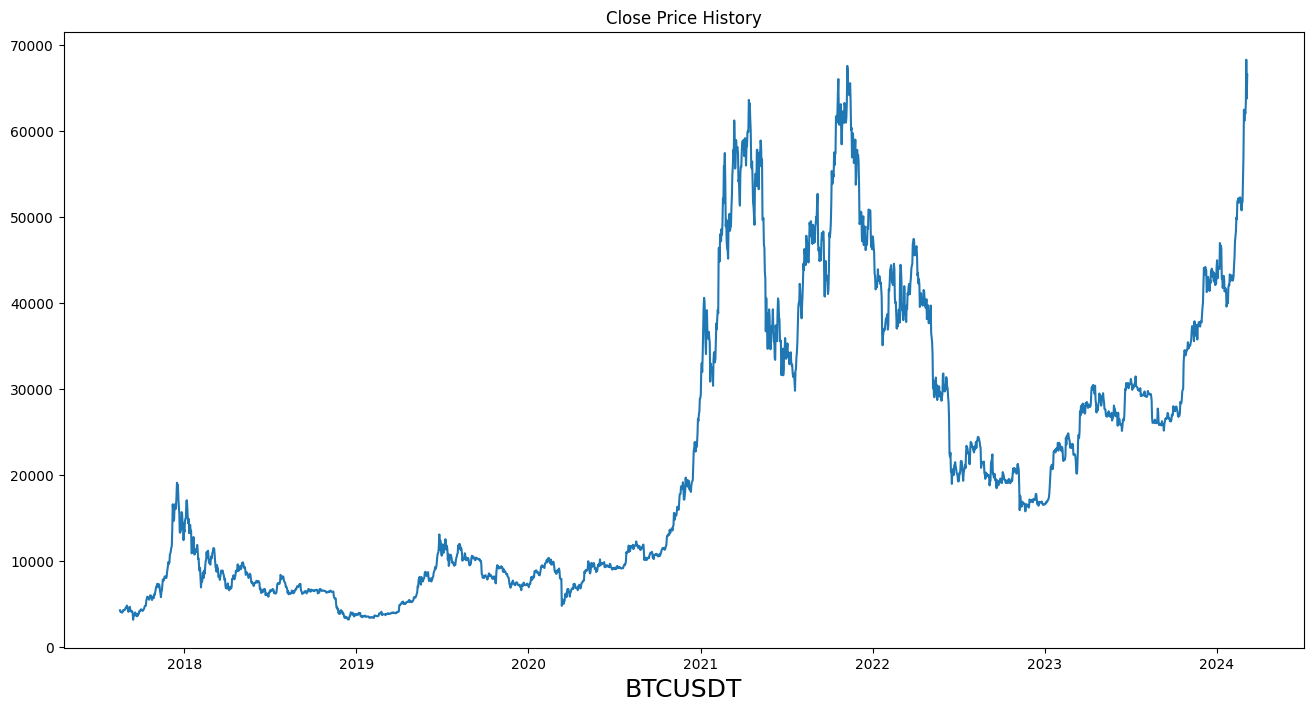

In [4]:
# Plot Close Price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_orig['close'])
plt.xlabel(f'{symbol}',fontsize=18)
plt.show()

### Feature Engineering - Feature Expansion

##### Indicators

In [5]:
# Apply All Technical Analysis Features
df_ta = bm.get_all_ta_features(df_orig)
df_ta

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,-3.239543e+02,795.150377,-0.407413,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4285.080000,0.000000,0.000000,0.000000
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,-5.833409e+02,-404.737887,-0.292396,-2.120323e+05,-6.777496e+09,...,-0.329976,-0.065995,-0.263980,3.912928,0.782586,3.130343,4226.635794,-4.123844,-4.211287,-4.123844
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,-3.039066e+02,-23.428124,-0.127888,-1.800200e+05,-1.209523e+10,...,-0.526923,-0.158181,-0.368742,-1.020499,0.421969,-1.442467,4192.618117,0.769405,0.766460,-3.386168
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,-4.900489e+02,-490.511146,-0.172344,-1.578854e+05,3.992858e+09,...,-0.777492,-0.282043,-0.495449,-4.267395,-0.515904,-3.751491,4152.526687,-1.296866,-1.305349,-4.639120
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,-4.880851e+02,-1182.254206,-0.138065,-1.422765e+05,-3.189062e+09,...,-1.100112,-0.445657,-0.654455,-4.437230,-1.300169,-3.137061,4098.990796,-1.720142,-1.735109,-6.279463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.736590,1.152390e+07,-541818.095910,0.267040,7.796302e+07,1.760210e+08,...,7.410799,5.946593,1.464207,10.180265,7.895607,2.284658,58522.565097,-0.642144,-0.644214,1346.583961
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.909030,1.154932e+07,-512823.186880,0.259424,7.149234e+07,1.838266e+09,...,7.668120,6.290898,1.377222,5.860376,7.488561,-1.628185,59674.562716,1.817615,1.801294,1372.877286
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.160050,1.162722e+07,-427988.026830,0.314392,1.234723e+08,2.282420e+10,...,8.455108,6.723740,1.731368,11.442303,8.279309,3.162993,62445.982910,8.130910,7.817244,1492.635610


### Assess Data for ML Readiness

In [6]:
# Check for NaN
df_ta.dropna(inplace=True)
print(df_ta.isnull().values.any())

False


In [7]:
# Check for Inf values
dfobj = df_ta.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [8]:
df_ta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2394 entries, 2017-08-17 to 2024-03-06
Data columns (total 91 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   open                       2394 non-null   float64
 1   high                       2394 non-null   float64
 2   low                        2394 non-null   float64
 3   close                      2394 non-null   float64
 4   volume                     2394 non-null   float64
 5   volume_adi                 2394 non-null   float64
 6   volume_obv                 2394 non-null   float64
 7   volume_cmf                 2394 non-null   float64
 8   volume_fi                  2394 non-null   float64
 9   volume_em                  2394 non-null   float64
 10  volume_sma_em              2394 non-null   float64
 11  volume_vpt                 2394 non-null   float64
 12  volume_vwap                2394 non-null   float64
 13  volume_mfi                 239

In [9]:
df_ta.describe()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2.394000e+03,2.394000e+03,2394.000000,2.394000e+03,2.394000e+03,...,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,21624.488083,22182.014937,21018.375998,21650.559357,72493.478821,5.157373e+06,8.547627e+05,0.075441,2.625640e+05,1.335517e+08,...,0.535363,0.523103,0.012260,-0.056806,-0.078172,0.021366,21681.833377,0.189211,0.114558,405.254496
std,16324.721273,16749.909963,15863.778251,16346.685373,83682.136518,4.082708e+06,1.888060e+06,0.131014,4.092332e+07,5.364688e+09,...,4.717291,4.480129,1.297403,11.766441,10.172764,5.267805,16281.388896,3.835218,3.882664,381.479118
min,3188.010000,3276.500000,2817.000000,3189.020000,228.108068,-5.833409e+02,-4.242190e+06,-0.407413,-4.542940e+08,-6.967929e+10,...,-14.753155,-12.048282,-5.694732,-54.120235,-47.515124,-17.225658,3470.687394,-39.504847,-50.260694,-25.578519
25%,8039.875000,8247.155000,7789.217500,8042.050000,29823.917373,6.659136e+05,-3.953720e+05,-0.017948,-5.109043e+06,-2.141379e+08,...,-2.140220,-1.982597,-0.674222,-7.312454,-5.760461,-3.185920,8066.131132,-1.433548,-1.443922,87.675609
50%,16612.325000,16865.890000,16316.500000,16618.105000,46086.336051,5.306172e+06,3.427170e+05,0.070560,3.820405e+04,5.680770e+06,...,0.180209,0.064644,0.010929,-1.145725,-0.717372,-0.523212,16926.345125,0.091121,0.091080,287.813180
75%,33299.377500,34459.997500,31859.500000,33376.822500,76868.843848,8.736933e+06,2.536147e+06,0.163076,6.464229e+06,3.219228e+08,...,3.507505,3.468073,0.772789,6.733800,5.695720,2.679847,34730.879341,1.759501,1.744201,678.907803
max,68245.710000,69000.000000,66222.400000,68245.710000,760705.362783,1.166048e+07,4.760994e+06,0.450024,3.829095e+08,1.062416e+11,...,18.690512,17.670667,4.708732,43.531483,31.897162,27.273324,63214.099764,22.501393,20.295222,1492.635610


### Add Prediction Target

In [10]:
# Specify Target
df_ta['TARGET'] = df_ta['close'].shift(-1)
df_target = df_ta.copy()
df_target[['close', 'TARGET']]

,close,TARGET
datetime,,
2017-08-17,4285.08,0.0
2017-08-18,4108.37,1.0
2017-08-19,4139.98,0.0
2017-08-20,4086.29,0.0
2017-08-21,4016.00,1.0
...,...,...
2024-03-02,61987.28,1.0
2024-03-03,63113.97,1.0
2024-03-04,68245.71,0.0


In [11]:
# Check for NaNs
nan_location = np.where(np.isnan(df_target))
nan_location

(array([2393], dtype=int64), array([91], dtype=int64))

In [12]:
# Remove last row to avoid NaNs
df_target.dropna(inplace=True)
df_target.tail()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
datetime,,,,,,,,,,,,,,,,,,,,,
2024-03-01,61130.99,63114.23,60777.00,62387.90,47737.93473,1.152448e+07,-516283.35932,0.280430,9.266181e+07,-3.667563e+08,...,5.580541,1.569078,15.956956,7.324443,8.632513,57632.662332,2.056110,2.035257,1355.933145,0.0
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.73659,1.152390e+07,-541818.09591,0.267040,7.796302e+07,1.760210e+08,...,5.946593,1.464207,10.180265,7.895607,2.284658,58522.565097,-0.642144,-0.644214,1346.583961,1.0
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.90903,1.154932e+07,-512823.18688,0.259424,7.149234e+07,1.838266e+09,...,6.290898,1.377222,5.860376,7.488561,-1.628185,59674.562716,1.817615,1.801294,1372.877286,1.0
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.16005,1.162722e+07,-427988.02683,0.314392,1.234723e+08,2.282420e+10,...,6.723740,1.731368,11.442303,8.279309,3.162993,62445.982910,8.130910,7.817244,1492.635610,0.0
2024-03-05,68245.71,69000.00,59005.00,63724.01,132696.78130,1.161982e+07,-560684.80813,0.236075,2.011696e+07,-1.052250e+10,...,7.046195,1.289821,21.201896,10.863827,10.338069,62613.487696,-6.625618,-6.855316,1387.113659,1.0


### Train Test Split

In [13]:
# Remove unwanted columns
df_tts = df_target.copy()
df_tts.drop(columns=["close", "open", "high", "low"], inplace=True)

In [14]:
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [15]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (1914, 87)
Shape of y_train:  (1914,)


### Build Initial Model

In [16]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [17]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [18]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    eval_metric_list = ["error", "logloss", eval_metric]
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    eval_metric_list = ["merror", "mlogloss", eval_metric]
    scoring = "f1"
else:
    scoring = "accuracy"

In [19]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric_list,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

### Find Hyperparameters

In [20]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [21]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 65, lr: 0.02 md: 5 gm: 2


### Train Model

In [22]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric_list,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [23]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'aucpr'], feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=65, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Performance Evaluation (Quick Overview)

In [24]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 1 1 0]


In [25]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [26]:
# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [27]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))

Average Accuracy K-Fold:  0.54
Std Deviation K-Fold:  0.01
Precision Score 0:  0.835
Precision Score 1:  0.788


### Feature Selection

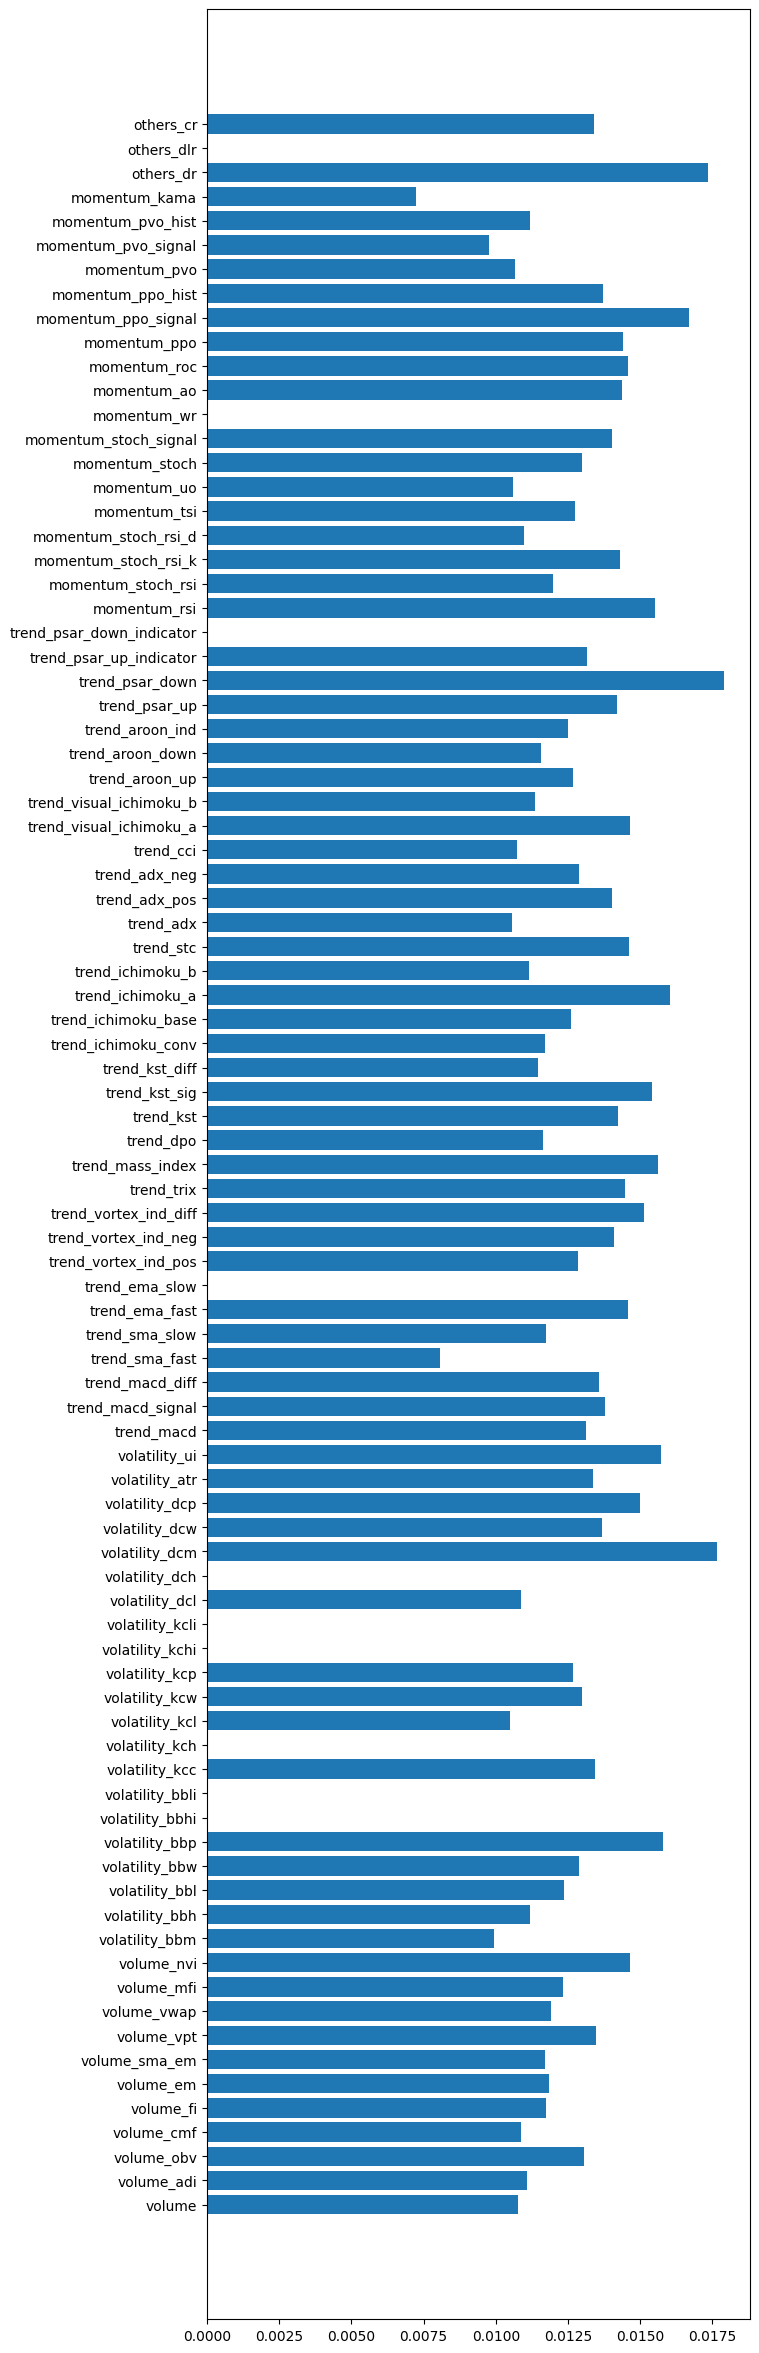

In [28]:
# Plot Feature Importances
fig = plt.figure(figsize=(7, 30))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.barh(importance_labels, importance_features)
plt.show()

In [29]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

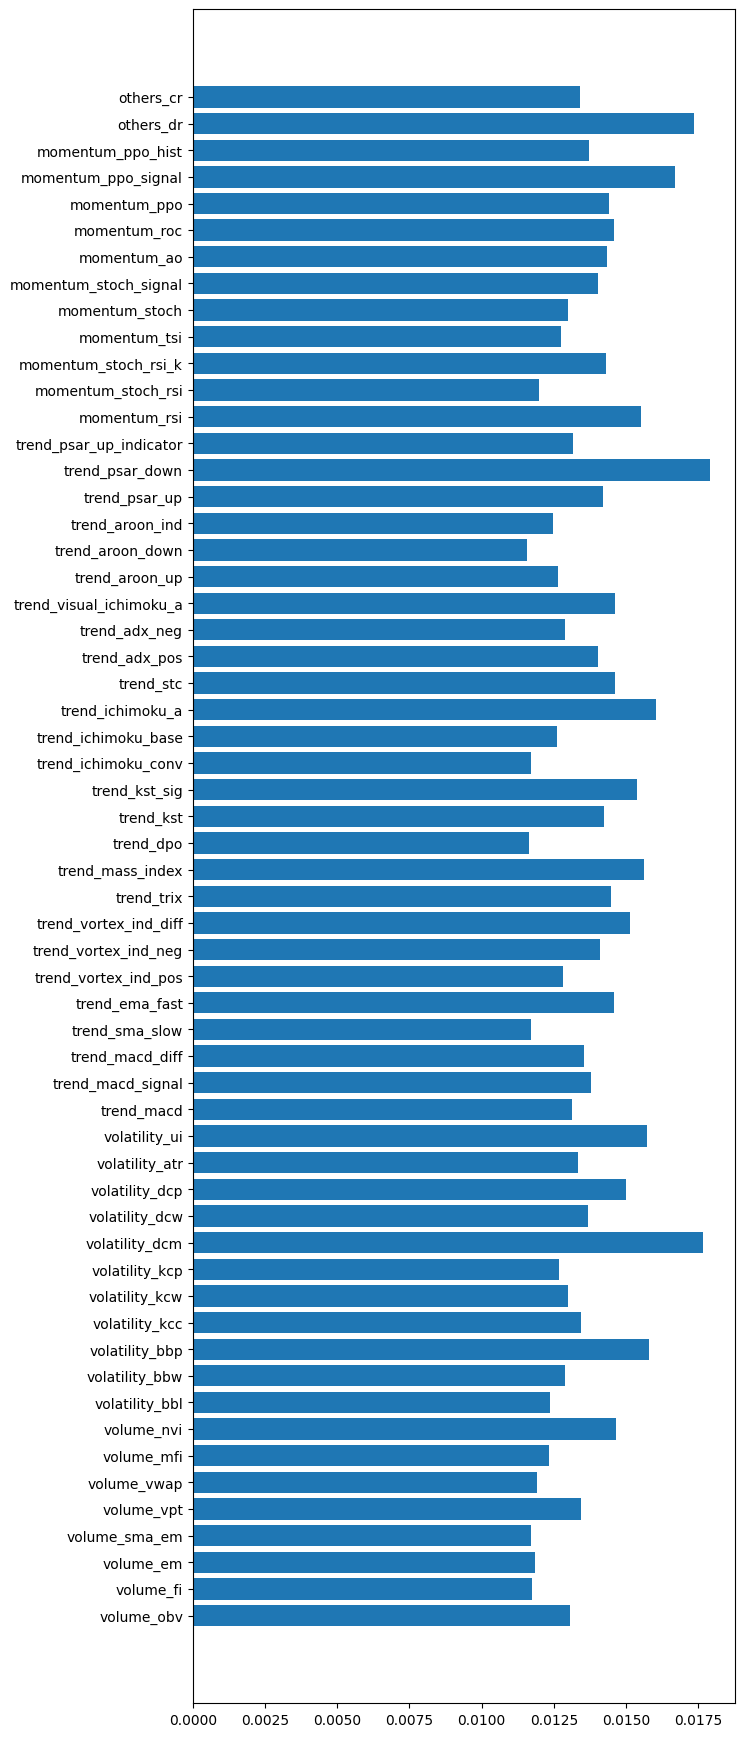

In [30]:
# Plot Recommended Features
fig = plt.figure(figsize=(7, 22))
plt.barh(recommended_feature_labels, recommended_feature_score)
plt.show()

### Train Test Split
with recommended features

In [31]:
df_tts2 = df_tts[recommended_feature_labels + ["TARGET"] ]

In [32]:
# Split into X and Y Data
X = df_tts2.iloc[:, : -1]
y = df_tts2.iloc[:, -1]

In [33]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1675, 58)
Shape of y_train:  (1675,)
Shape of X_test:  (718, 58)
Shape of y_test:  (718,)
Size Matches:  True


### Build Model

In [34]:
# XGBOOST Classifier
classifier_2 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric_list,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [35]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier_2.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'aucpr'], feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=65, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### Make Predictions

In [36]:
# Get Predictions Training
train_yhat = classifier_2.predict(X_train)
train_yhat_proba = classifier_2.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 1 1 1 1 1 1 0 1 1]
Preds Probabilities Training Data: 
 [[0.5174066  0.48259345]
 [0.3458925  0.6541075 ]
 [0.4465115  0.5534885 ]]


In [37]:
# Get Predictions Test
test_yhat = classifier_2.predict(X_test)
test_yhat_proba = classifier_2.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 1 0 0 1]
Preds Probabilities Training Data: 
 [[0.51232994 0.48767006]
 [0.53603315 0.46396685]
 [0.5541688  0.44583118]]


In [38]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [39]:
# Training Results
train_results = cross_val_score(classifier_2, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [40]:
# Retrieve performance metrics
results = classifier_2.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

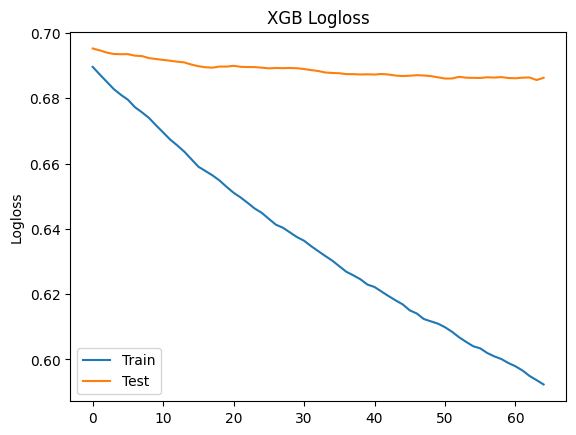

In [41]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

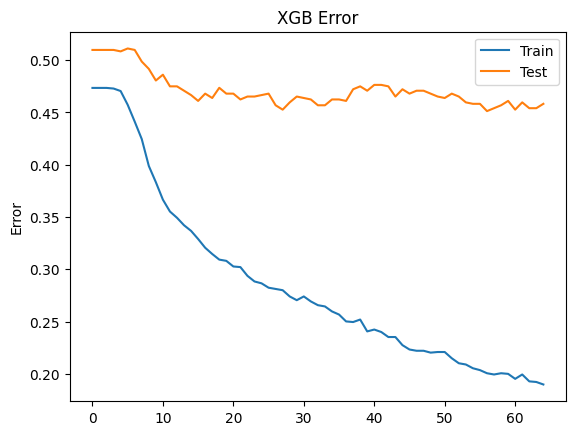

In [42]:
# Plot error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


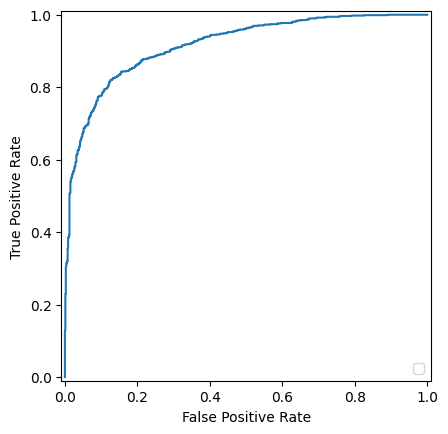

In [43]:
# Plot Training ROC Curve
y_score = classifier_2.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_score)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


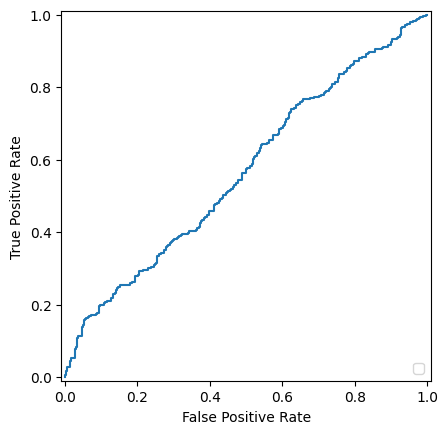

In [44]:
# Plot Training ROC Curve
y_score = classifier_2.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.show()

In [45]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [46]:
# Training and Test Results
train_results = cross_val_score(classifier_2, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier_2, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [47]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.55
Std Dev K-Fold 0.01
Precision Score 0 0.869
Precision Score 1 0.773
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.51
Std Dev K-Fold 0.07
Precision Score 0 0.573
Precision Score 1 0.525



In [48]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.87      0.70      0.78       793
         1.0       0.77      0.90      0.83       882

    accuracy                           0.81      1675
   macro avg       0.82      0.80      0.81      1675
weighted avg       0.82      0.81      0.81      1675



In [49]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.57      0.40      0.47       366
         1.0       0.52      0.69      0.60       352

    accuracy                           0.54       718
   macro avg       0.55      0.54      0.53       718
weighted avg       0.55      0.54      0.53       718



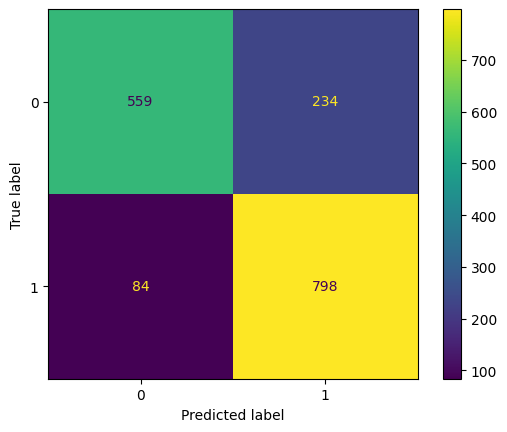

In [50]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

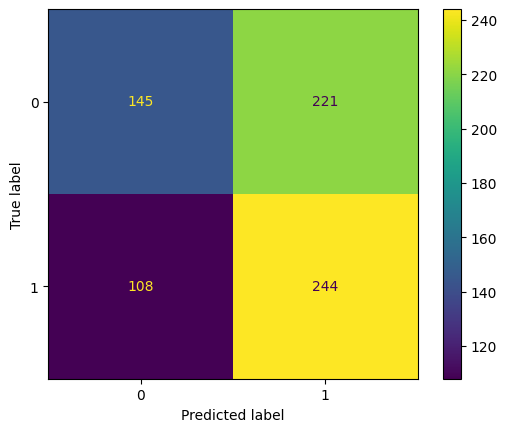

In [51]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

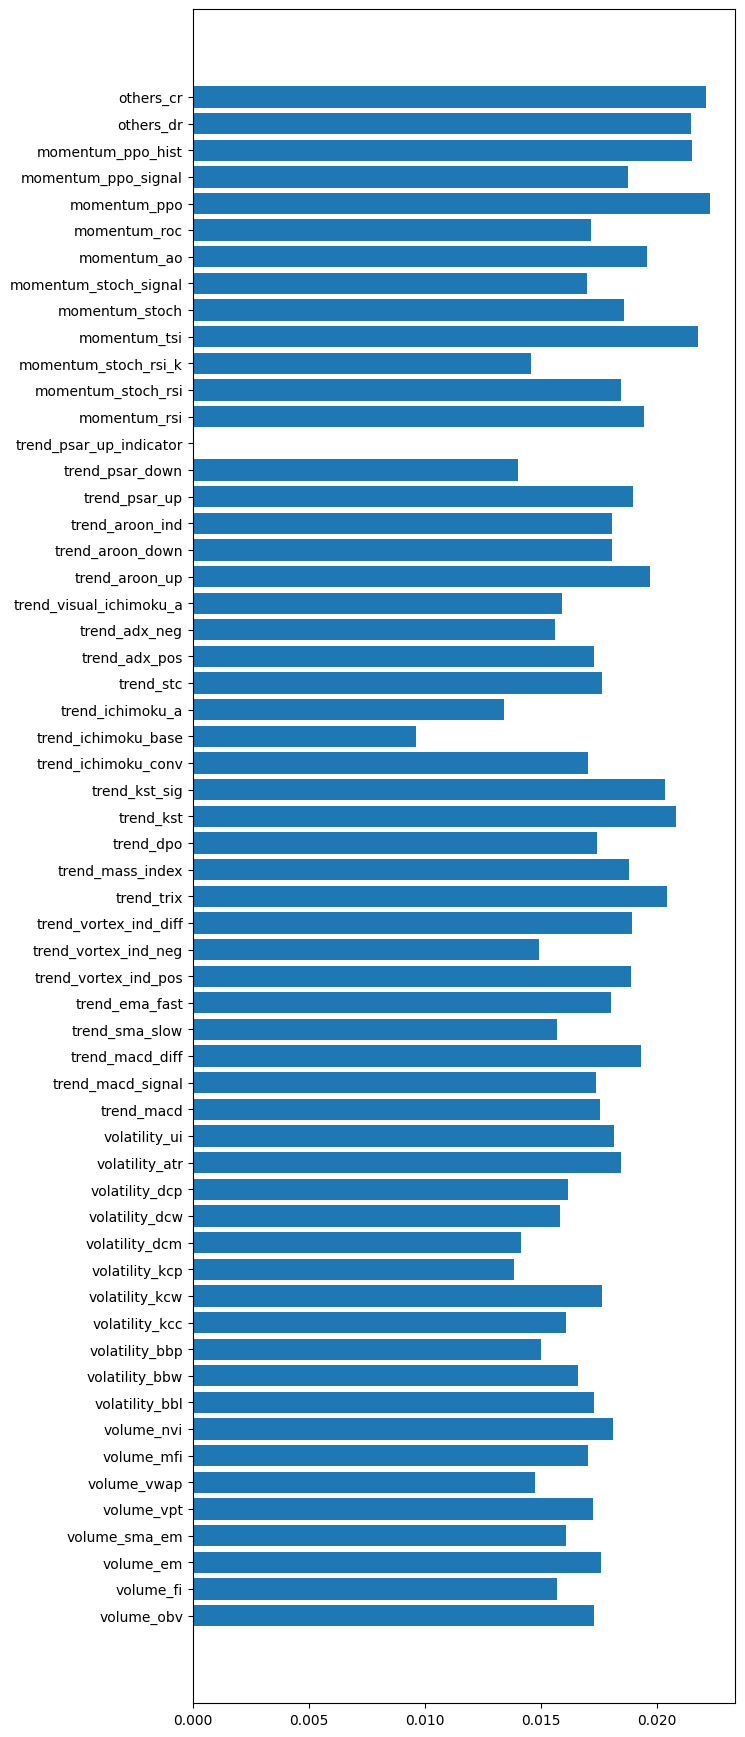

In [52]:
# Plot Feature Importances
fig = plt.figure(figsize=(7, 22))
importance_labels = X.columns
importance_features = classifier_2.feature_importances_
plt.barh(importance_labels, importance_features)
plt.show()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

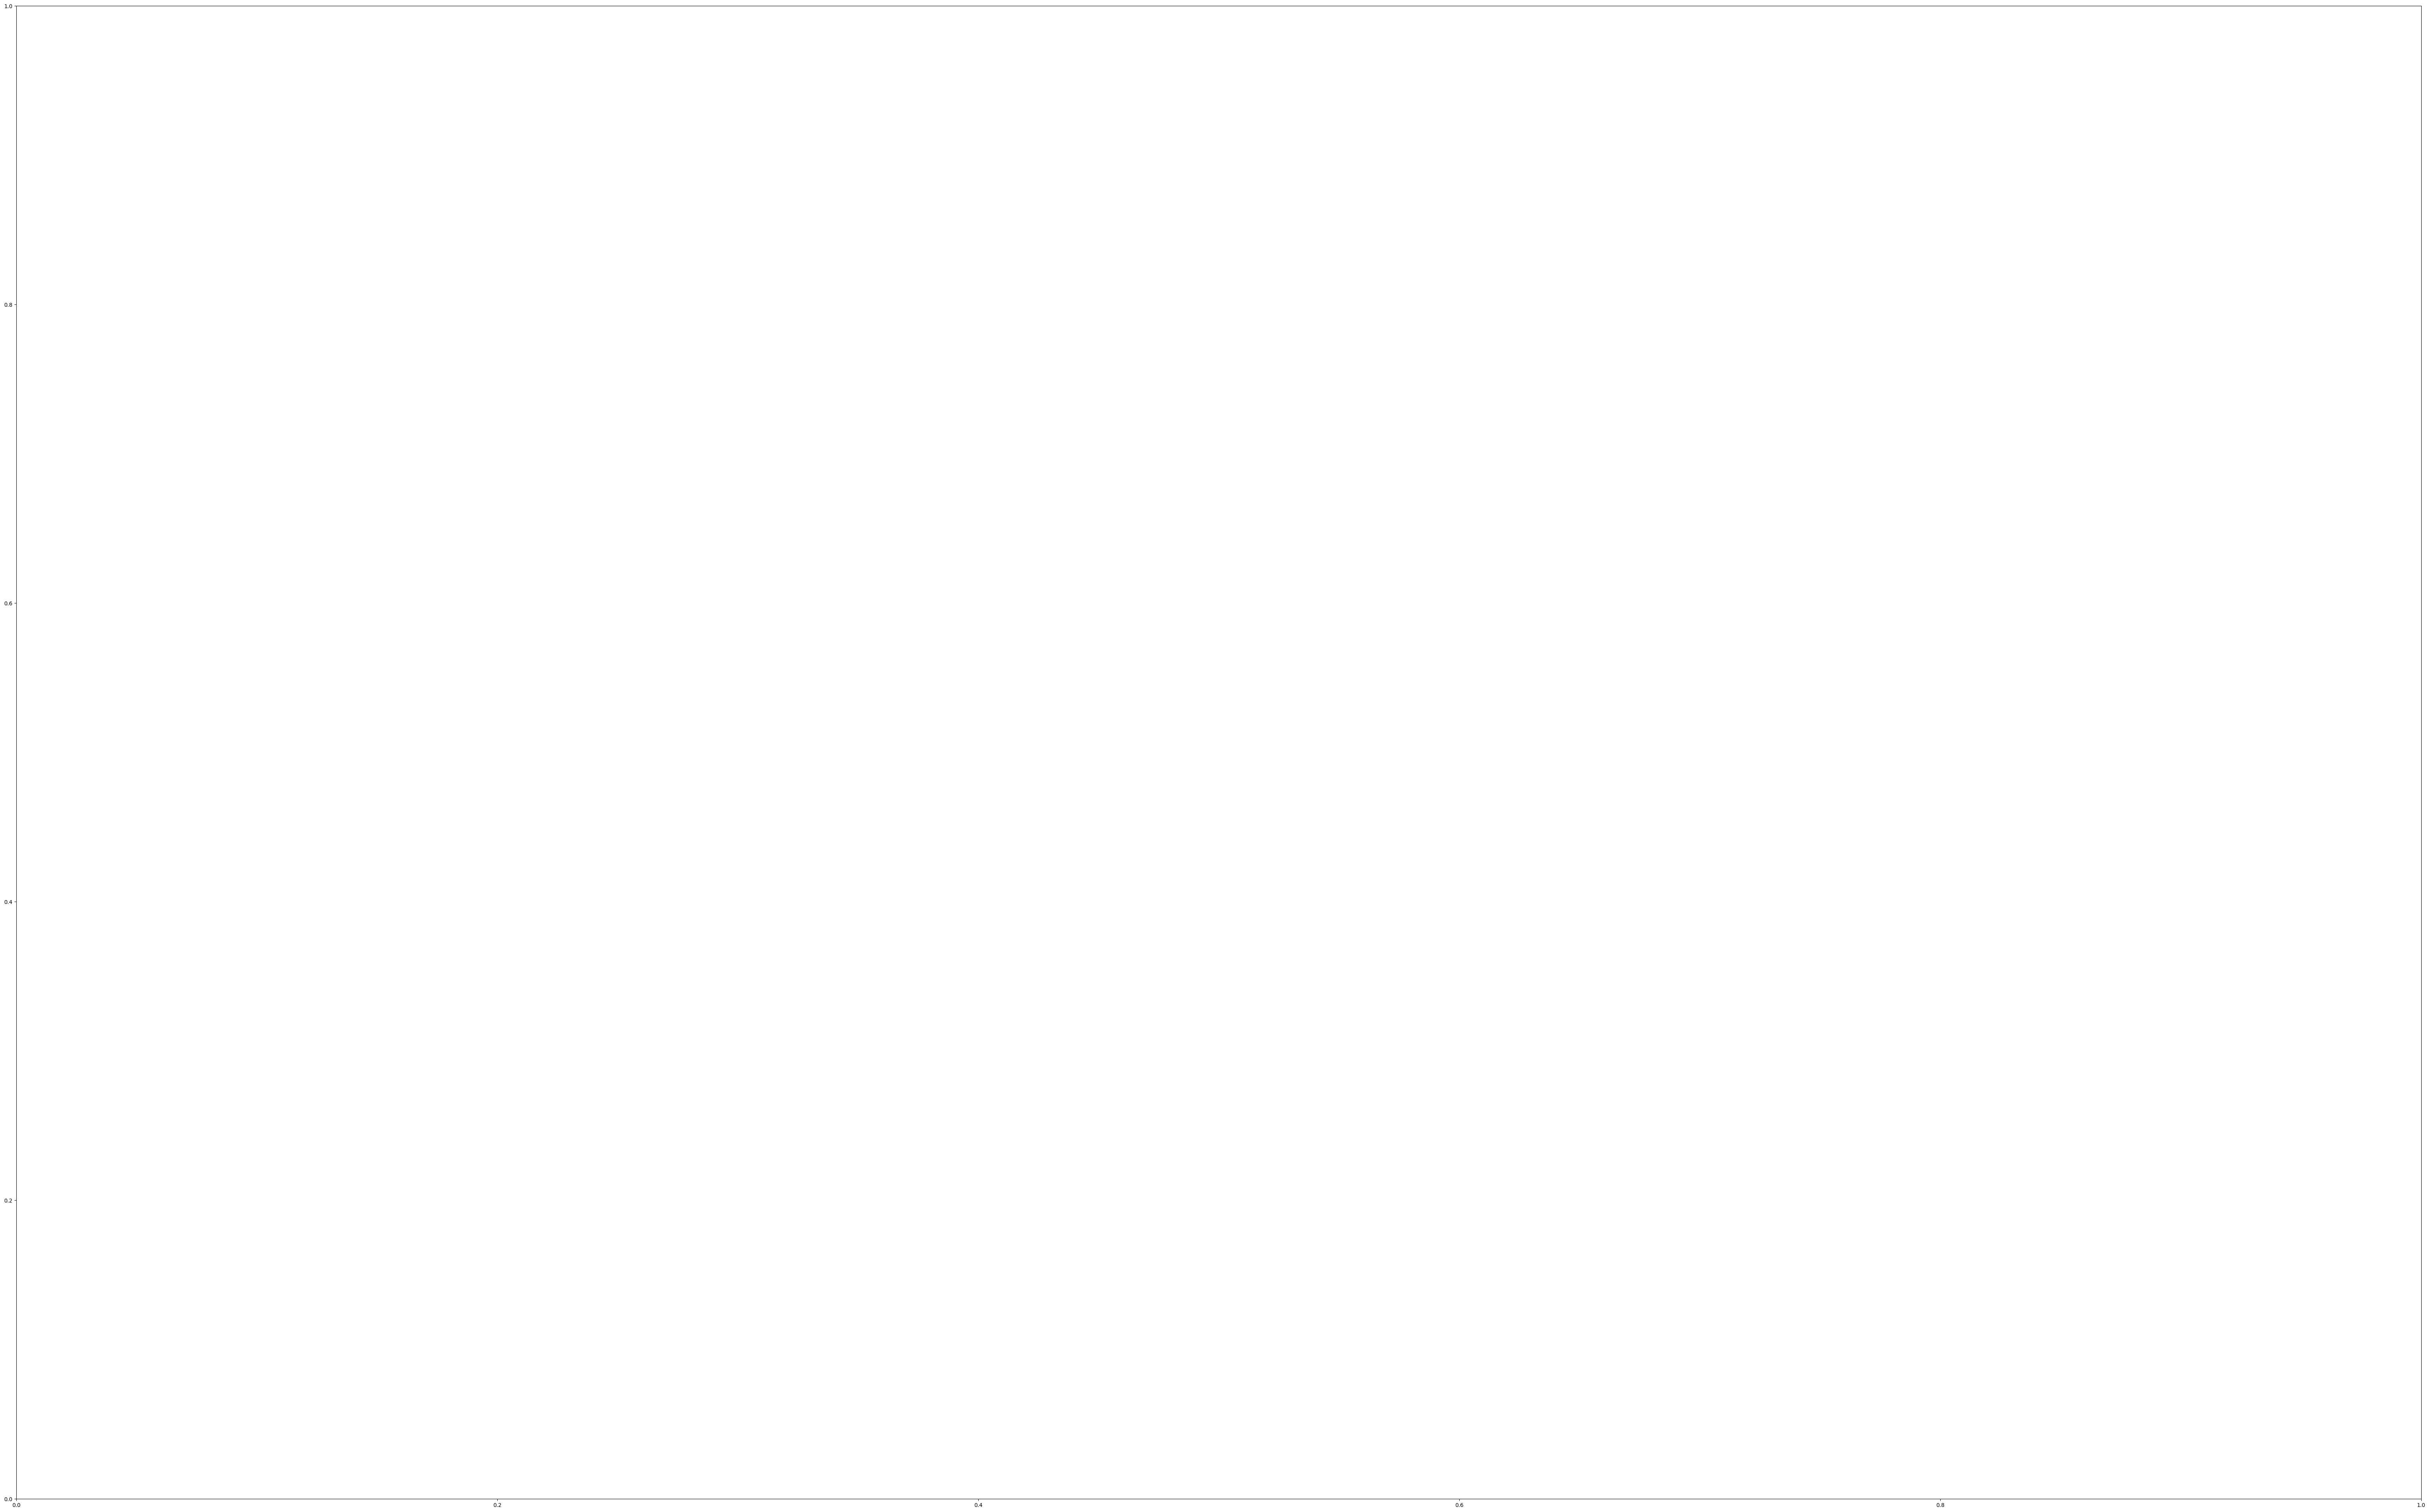

In [53]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier_2)